<a href="https://colab.research.google.com/github/omarhatem97/ANER_DEV/blob/main/NER_ANER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine Tuning Arabert Model to do NER Task

### Environment setup

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
    !nvidia-smi

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [ ]:

# get the dataset 
!gdown --id  1bYDqmEYKpVmVyGc9Vmz3W_2bsPMel6UC


# The label_lsit file
!gdown --id  1th3j28peQf-asgodeaGo-04aIARN0QoL







!pip install transformers 
!pip install pyarabic
!pip install seqeval
!git clone https://github.com/aub-mind/arabert

Downloading...
From: https://drive.google.com/uc?id=1bYDqmEYKpVmVyGc9Vmz3W_2bsPMel6UC
To: /content/dataset_1.0.txt
6.03MB [00:00, 95.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1th3j28peQf-asgodeaGo-04aIARN0QoL
To: /content/label_list.txt
100% 1.22k/1.22k [00:00<00:00, 3.01MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-1S27QQYAsFpxXDgs2slPq3D10QvgA20
To: /content/aqmar_test.txt
100% 31.5k/31.5k [00:00<00:00, 12.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Iv-FwkBt0MXsqNG1Sb7HWhslrxCSk1X4
To: /content/aqmar_label_list.txt
100% 95.0/95.0 [00:00<00:00, 206kB/s]
     |████████████████████████████████| 2.5MB 5.2MB/s 
     |████████████████████████████████| 901kB 44.4MB/s 
     |████████████████████████████████| 3.3MB 30.4MB/s 
     |████████████████████████████████| 133kB 4.9MB/s 
     |████████████████████████████████| 51kB 2.8MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp37-none-any.whl size=16184 sha256=fb3b2dce1dfa5ed53c0f6aa9de28

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from  tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from collections import Counter


In [ ]:
from arabert.preprocess import ArabertPreprocessor
import numpy as np

from seqeval.metrics import accuracy_score, f1_score, precision_score, recall_score
from transformers import AutoConfig, AutoModelForTokenClassification, AutoTokenizer, BertForTokenClassification, AdamW, get_linear_schedule_with_warmup
from transformers import Trainer , TrainingArguments
from transformers.trainer_utils import EvaluationStrategy
from transformers.data.processors.utils import InputFeatures
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.utils import resample
import logging
import torch
from torch import nn

%load_ext google.colab.data_table

## Preprocessing

In this part, we take the dataset, and convert it to list of sentences using the newline token to get the end of each sentence


This function will make a dataset of sentences 

returns: list of shape: 
  [no_sentences] *  [ [words] , [tags] ]

In [ ]:
def read_dataset(path):
  with open(path,'r',encoding='utf-8') as f:
    data = []
    sentence = []
    label = []
    for line in f:
      # line = line.replace(u'\u200e','')
      # line = line.replace(u'\ufeff','')
      if '[NEWLINE]' in line:
        if len(sentence) > 0:
          data.append([sentence,label])
          sentence = []
          label = []
        continue
      line = line.strip('\n')
      splits = line.split(' ')
      sentence.append(splits[0])
      label.append(splits[1])
    if len(sentence) > 0:
      data.append([sentence,label])
  return data

Here we can see after converting the dataset into sentences, that we have 15763 Sentence

In [ ]:

data = read_dataset('dataset_1.0.txt')
print(len(data))


15763


In [ ]:
df = pd.DataFrame(data, columns=['text', 'tags'])
df.head(1)


,text,tags
0,"[جمهورية, جنوب, السودان, ،, هي, دولة, تقع, في,...","[B-Nation, I-Nation, I-Nation, O, O, O, O, O, ..."


Here we get the list of all classes we have

In [ ]:
label_list = list(pd.read_csv('label_list.txt', header=None, index_col=0).T)

label_map = { v:index for index, v in enumerate(label_list) }
inv_label_map = {i: label for i, label in enumerate(label_list)}

print(label_map)
print(inv_label_map)

{'O': 0, 'B-Artist': 1, 'I-Artist': 2, 'B-Sound': 3, 'I-Sound': 4, 'B-Educational': 5, 'I-Educational': 6, 'B-Building-Grounds': 7, 'I-Building-Grounds': 8, 'B-Population-Center': 9, 'B-Nation': 10, 'B-State-or-Province': 11, 'I-State-or-Province': 12, 'B-Water-Body': 13, 'I-Water-Body': 14, 'B-Land-Region-Natural': 15, 'I-Land-Region-Natural': 16, 'B-Software': 17, 'I-Software': 18, 'B-Scientist': 19, 'B-Book': 20, 'I-Book': 21, 'I-Scientist': 22, 'B-Group': 23, 'B-Celestial': 24, 'B-Police': 25, 'I-Police': 26, 'I-Population-Center': 27, 'I-Celestial': 28, 'B-Engineer': 29, 'I-Engineer': 30, 'B-Projectile': 31, 'B-Government': 32, 'I-Government': 33, 'B-Commercial': 34, 'I-Commercial': 35, 'B-Continent': 36, 'B-Air': 37, 'I-Air': 38, 'B-Other_PER': 39, 'I-Other_PER': 40, 'I-Group': 41, 'B-Politician': 42, 'I-Politician': 43, 'B-Athlete': 44, 'I-Athlete': 45, 'B-Religious_ORG': 46, 'I-Religious_ORG': 47, 'B-Path': 48, 'I-Path': 49, 'B-Media': 50, 'I-Media': 51, 'B-Non-Governmental': 5

## Dataset splits


We splitthe Dataset into:  90% Train, 10% Valdiation, and 10% Test

In [ ]:
 train_data, test_data = train_test_split(data,test_size= 0.2)

 test_data , eval_data = train_test_split(test_data,test_size= 0.5)

NameError: ignored

In [ ]:
print(len(train_data))
print(len(test_data))
print(len(eval_data))

NameError: ignored

Here we get the frequency of each class in dataset

In [ ]:
print(Counter([ label for sentence in train_data for label in sentence[1]]))
print(Counter([ label for sentence in test_data for label in sentence[1]]))



Counter({'O': 339640, 'B-Population-Center': 4486, 'B-Nation': 4000, 'I-Politician': 2831, 'B-Group': 2273, 'B-Politician': 2221, 'B-Water-Body': 1353, 'I-Religious_PER': 1333, 'B-State-or-Province': 1186, 'I-Artist': 1043, 'I-Water-Body': 1009, 'I-Population-Center': 980, 'I-Scientist': 948, 'I-Building-Grounds': 942, 'B-Other_PER': 936, 'I-Commercial': 916, 'I-Non-Governmental': 911, 'B-Artist': 906, 'B-Commercial': 851, 'I-Other_PER': 840, 'I-Nation': 820, 'I-Government': 814, 'B-Scientist': 765, 'B-Building-Grounds': 711, 'I-Air': 676, 'B-Religious_PER': 650, 'B-Celestial': 627, 'I-Book': 621, 'B-Non-Governmental': 621, 'I-Educational': 588, 'B-Government': 571, 'B-Police': 554, 'I-Athlete': 535, 'B-Athlete': 533, 'I-Software': 528, 'I-Media': 519, 'B-Air': 507, 'B-Continent': 501, 'I-Group': 472, 'I-Sports': 466, 'I-Police': 464, 'I-Hardware': 456, 'I-State-or-Province': 435, 'B-Educational': 428, 'B-Media': 415, 'B-Land-Region-Natural': 403, 'B-Software': 402, 'B-Sports': 398, 'B

Here we get a histogram of number of tokens in each sentence, to choose  a suitiable size for BERT MAX_LEN

Training Sentence Lengths: 


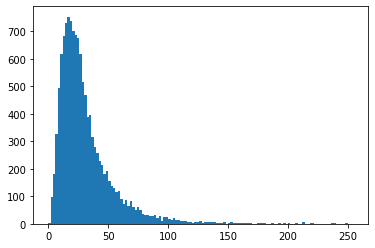

6
Testing Sentence Lengths: 


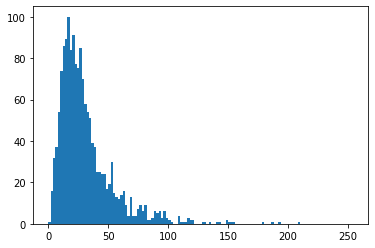

0


In [ ]:
print("Training Sentence Lengths: ")
plt.hist([ len(sentence[0]) for sentence in train_data],bins=range(0,256,2))
plt.show()
print(sum([len(sentence[0]) > 256 for sentence in train_data]))

print("Testing Sentence Lengths: ")
plt.hist([ len(sentence[0]) for sentence in test_data],bins=range(0,256,2))
plt.show()
print(sum([len(sentence[0]) > 256 for sentence in test_data]))

## Training


### Model Config

Here, we define some constants to use 

In [ ]:
DATASET_NAME = 'Fine_GRATED'
MODEL_NAME = 'aubmindlab/bert-base-arabertv02'
TASK_NAME = 'tokenclassification'

#######  TODO: Make it 256 again
MAX_LEN = 256
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16
EPOCHS = 10
MODEL_PATH = "model"

TOKENIZER = AutoTokenizer.from_pretrained(MODEL_NAME)

### Dataset


Here we define the Dataset class, and how to process batches before training


In [ ]:
class NERDataset:
  def __init__(self, texts, tags, label_list, model_name, max_length):
    self.texts = texts
    self.tags = tags
    self.label_map = {label: i for i, label in enumerate(label_list)}
    self.preprocessor = ArabertPreprocessor(model_name.split("/")[-1])    
    self.pad_token_label_id = torch.nn.CrossEntropyLoss().ignore_index
    # Use cross entropy ignore_index as padding label id so that only
    # real label ids contribute to the loss later.
    self.tokenizer = AutoTokenizer.from_pretrained(model_name)
    self.max_length = max_length

     
  def __len__(self):
    return len(self.texts)
  
  def __getitem__(self, item):
    textlist = self.texts[item]
    tags = self.tags[item]

    tokens = []
    label_ids = []
    for word, label in zip(textlist, tags):      
      clean_word = self.preprocessor.preprocess(word)  
      word_tokens = self.tokenizer.tokenize(clean_word)

  
      if len(word_tokens) > 0:
        tokens.extend(word_tokens)    
        # Use the real label id for the first token of the word, and padding ids for the remaining tokens
        label_ids.extend([self.label_map[label]] + [self.pad_token_label_id] * (len(word_tokens) - 1))
 
    # Account for [CLS] and [SEP] with "- 2" and with "- 3" for RoBERTa.
    special_tokens_count = self.tokenizer.num_special_tokens_to_add()
    if len(tokens) > self.max_length - special_tokens_count:
      tokens = tokens[: (self.max_length - special_tokens_count)]
      label_ids = label_ids[: (self.max_length - special_tokens_count)]
  
    #Add the [SEP] token
    tokens += [self.tokenizer.sep_token]
    label_ids += [self.pad_token_label_id]
    token_type_ids = [0] * len(tokens)

    #Add the [CLS] TOKEN
    tokens = [self.tokenizer.cls_token] + tokens
    label_ids = [self.pad_token_label_id] + label_ids
    token_type_ids = [0] + token_type_ids

    input_ids = self.tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    attention_mask = [1] * len(input_ids)

    # ana we ant {pad}
    # 1    1  1   0  0
    # [cls] B-loc O O B-loc [sep] [pad]
    #  -100    2   0  0      -100 

    # Zero-pad up to the sequence length.
    padding_length = self.max_length - len(input_ids)

    input_ids += [self.tokenizer.pad_token_id] * padding_length
    attention_mask += [0] * padding_length
    token_type_ids += [0] * padding_length
    label_ids += [self.pad_token_label_id] * padding_length

    assert len(input_ids) == self.max_length
    assert len(attention_mask) == self.max_length
    assert len(token_type_ids) == self.max_length
    assert len(label_ids) == self.max_length

    # if item < 5:
    #   print("*** Example ***")
    #   print("tokens:", " ".join([str(x) for x in tokens]))
    #   print("input_ids:", " ".join([str(x) for x in input_ids]))
    #   print("attention_mask:", " ".join([str(x) for x in attention_mask]))
    #   print("token_type_ids:", " ".join([str(x) for x in token_type_ids]))
    #   print("label_ids:", " ".join([str(x) for x in label_ids]))
    
    return {
        'input_ids' : torch.tensor(input_ids, dtype=torch.long),
        'attention_mask' : torch.tensor(attention_mask, dtype=torch.long),
        'token_type_ids' : torch.tensor(token_type_ids, dtype=torch.long),
        'labels' : torch.tensor(label_ids, dtype=torch.long)       
    }

Here we create The datasets for train,val, and test

In [ ]:


train_dataset = NERDataset(
    texts=[x[0] for x in train_data],
    tags=[x[1] for x in train_data],
    label_list=label_list,
    model_name=MODEL_NAME,
    max_length=MAX_LEN
    )

test_dataset = NERDataset(
    texts=[x[0] for x in test_data],
    tags=[x[1] for x in test_data],
    label_list=label_list,
    model_name=MODEL_NAME,
    max_length=MAX_LEN
    )

eval_dataset = NERDataset(
    texts=[x[0] for x in eval_data],
    tags=[x[1] for x in eval_data],
    label_list=label_list,
    model_name=MODEL_NAME,
    max_length=MAX_LEN
    )

### Model init and Data Loaders 

Here we initalize the model as a Brt model for token classification

In [ ]:

def model_init():
    return BertForTokenClassification.from_pretrained(MODEL_NAME,
                                                      return_dict=True,
                                                      num_labels=len(label_map),output_attentions = False,
                                                      output_hidden_states = False)





In [ ]:
my_model = model_init()

Some weights of the model checkpoint at aubmindlab/bert-base-arabertv02 were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initia

In [ ]:
print(my_model)

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(64000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [ ]:
train_data_loader = DataLoader(dataset=train_dataset,batch_size=TRAIN_BATCH_SIZE,shuffle= True)
eval_data_loader = DataLoader(dataset=eval_dataset,batch_size=VALID_BATCH_SIZE,shuffle= True)
test_data_loader = DataLoader(dataset=test_dataset,batch_size=TEST_BATCH_SIZE,shuffle= True)

### Train, Eval, Test Functions

#### Helper Funvtions

In [ ]:

def align_predictions(predictions, label_ids):
    """
        Takes batch of senteces, and the logits for every word in every sentences 
        it will exclude the padding tokens 
        
        predictions:  [ [ [logits] ] ]
        label_ids: [[Sentence1], [Sentence2]]
        
        returns : predicition label list of shape (no_sentences, no_words_in_sentece)
                  true label list of shape (no_sentences, no_words_in_sentece)
                  
                  output example: y_true = [['O', 'O', 'O', 'B-MISC', 'I-MISC', 'I-MISC', 'O'], ['B-PER', 'I-PER', 'O']]
                                  y_pred = [['O', 'O', 'B-MISC', 'I-MISC', 'I-MISC', 'I-MISC', 'O'], ['B-PER', 'I-PER', 'O']]
    """
   
    preds = np.argmax(predictions, axis=2)
    
   

    batch_size, seq_len = preds.shape

    assert(preds.shape == label_ids.shape)
    
    out_label_list = [[] for _ in range(batch_size)]
    preds_list = [[] for _ in range(batch_size)]

    for i in range(batch_size):
        for j in range(seq_len):
            
            if label_ids[i] [j] != torch.nn.CrossEntropyLoss().ignore_index:
                
                out_label_list[i].append(inv_label_map[label_ids[i][j]])
                preds_list[i].append(inv_label_map[preds[i][j]])

    return preds_list, out_label_list

In [ ]:
def compute_metrics(predictions, labels , generate_report = False):
    
    preds_list, out_label_list = align_predictions(predictions,labels)
    
    
    if generate_report:
        try:         
            print(classification_report(out_label_list, preds_list))
        except:
            print('There Was an error while generating the classification report!')
            
    return {
        "accuracy_score": accuracy_score(out_label_list, preds_list),
        "precision": precision_score(out_label_list, preds_list),
        "recall": recall_score(out_label_list, preds_list),
        "f1": f1_score(out_label_list, preds_list),
    }


#### Train Function

In [ ]:
def train_epoch(train_dl, model, optimizer,scheduler,device):

    ###########################################
    #                                         #
    #           TRAINING STARTS HERE          #
    #                                         #
    ###########################################

    model.train()

    final_loss = 0

    i = 0

    for data in tqdm(train_dl, total = len(train_dl)):

        # BATCH

        # Send Data to GPU
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        token_type_ids = data['token_type_ids'].to(device)
        labels = data['labels'].to(device)


        optimizer.zero_grad()



        # we can also pass token_type_ids

        outputs = model(input_ids = input_ids,
                        token_type_ids=token_type_ids,
                        attention_mask=attention_mask,
                        labels=labels)

        #### For watching training 
        # if i==2:
        #     a= []
        #     b = []
        #     print(outputs.logits[5].shape)
        #     print(labels[5].shape)
        #     for word in outputs.logits[5]:
        #         a.append(np.argmax(word.to('cpu').detach().numpy()))
        #     for l in labels[5]:
        #         b.append(l)
        #     print(len(a), len(b))
        #     print  ( ' CORRECT:  ',torch.sum(torch.tensor(a) == torch.tensor(b)) )
        #     for aa,bb in zip(a,b):
        #         print(f' predicted : {aa} ,   Label:  {bb}')

        # i+=1

        #print(outputs)

        # TODO: Watchout forthis 
        loss = outputs.loss

        loss.backward()

        # Do we need it ? 
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step()

        final_loss += loss.item()



    print(final_loss)

    return final_loss / len(train_dl)

#### Validation Function

In [ ]:
def eval_epoch(eval_dl, model,device, generate_report = False):

  ###########################################
  #                                         #
  #           EVALUATION STARTS HERE        #
  #                                         #
  ###########################################

    model.eval()

    final_loss = 0

    # 3D array to store every sentence and its logits (2D array)
    all_preds = []
    
    # 2D array to store every sentence and its labels
    all_labels = []

    for data in tqdm(eval_dl, total = len(eval_dl)):

        # BATCH

        # Send Data to GPU
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        token_type_ids = data['token_type_ids'].to(device)
        labels = data['labels'].to(device)



        outputs = model(input_ids = input_ids,
                        token_type_ids=token_type_ids,
                        attention_mask=attention_mask,
                        labels=labels)

        
        loss = outputs[0]

        final_loss += loss.item()
        
        logits = outputs.logits.detach().cpu().numpy()
        labels = labels.to('cpu').numpy()
        
        
        
        
        all_preds.extend(logits)
        all_labels.extend(labels)
      
        
 
    all_preds = np.array(all_preds)
    all_labels = np.asarray(all_labels)
    
   
   
    # this will first clean the data from the padding tokens, then will calcuate the metrics
    metrics = compute_metrics(all_preds, all_labels, generate_report)
    

    final_loss = final_loss / len(eval_dl)


    
    return final_loss, metrics

#### Test Function

In [ ]:
def model_test(test_dl,model,device):

    ###########################################
    #                                         #
    #           TEST STARTS HERE              #
    #                                         #
    ###########################################
    with torch.no_grad():
        model.to(device)
        model.eval()
        final_loss = 0
        all_predictions = []
        all_labels = []
        for data in tqdm(test_dl, total = len(test_dl)):

            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            token_type_ids = data['token_type_ids'].to(device)
            labels = data['labels'].to(device)



            outputs = model(input_ids = input_ids,
                            token_type_ids=token_type_ids,
                            attention_mask=attention_mask,
                            labels=labels)
            
            
            loss = outputs.loss

            predictions = outputs.logits

            all_labels.extend(labels.to('cpu').numpy())
            all_predictions.extend(outputs.logits.to('cpu').numpy())

            final_loss += loss.item()

            #print(np.array(all_predictions).shape)

            # all_labels=  torch.tensor(all_labels).to('cpu').numpy()
            # all_predictions = torch.tensor(all_predictions).to('cpu').numpy()

            
            
        metrics = \
        compute_metrics(predictions=np.asarray(all_predictions), labels=np.asarray(all_labels))

        accuracy_score = metrics['accuracy_score']
        precision= metrics['precision']
        recall= metrics['recall']
        f1= metrics['f1']

        print(f' Accuracy: {accuracy_score}')
        print(f' Precision: {precision}')
        print(f' Recall: {recall}')
        print(f' F1: {f1}')


        final_loss /= len(test_dl) 

        print(f'Final Test Loss is: {final_loss}' )


### Train Loop

This part is in case we wann continue from a  trined model, so we load the state dict and continue upon it 

In [ ]:


! cp drive/MyDrive/Models/model .

model = model_init().to(device)
model.load_state_dict(torch.load('model', map_location='cpu'))

Here we configure an optimizer and a scheduler

In [ ]:
optimizer = AdamW(model.parameters(), lr=5e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

NameError: ignored

#### Train Loop

In [ ]:
for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)


    train_loss = train_epoch(
                            model = model,
                            train_dl = train_data_loader ,    
                            device = device,
                            optimizer =optimizer, 
                            scheduler = scheduler, 

    )
    print(f'Train loss {train_loss}')


    eval_loss, metrics = eval_epoch(
                                model = model,
                                eval_dl = eval_data_loader ,    
                                device = device,
                                generate_report = False
    )

    print(f'Eval loss: {eval_loss}')
    print(f'Eval Metrics:  {metrics}')
    print('--------------------------------------------------------------------')

### Saving Model

In [ ]:

save_model_name = 'full_model_v3'


torch.save(model, save_model_name)

!cp full_model_v2 drive/MyDrive/Models/

### Testing

In [ ]:
! cp drive/MyDrive/Models/full_model_v2 .

In [ ]:
############ TESTING ###########


# test_model = model_init()
# test_model.load_state_dict(torch.load('model_v1', map_location='cpu'))

test_model = torch.load('full_model_v2' ,map_location='cpu')

model_test(test_dl= test_data_loader,model=test_model, device= device)


 Accuracy: 0.9967066235732112
 Precision: 0.9761073825503356
 Recall: 0.9811117107393416
 F1: 0.9786031489705288
Final Test Loss is: 0.018308890143107603


Testing result 


Accuracy: 0.9967066235732112
 Precision: 0.9761073825503356
 Recall: 0.9811117107393416
 F1: 0.9786031489705288
Final Test Loss is: 0.018308890143107603

### Test on one sentence 

This function is to test our trained model, on a sentence 

In [ ]:
def predict_sent(sentences):

    input_ids  = TOKENIZER.encode(sentences, return_tensors='pt')

    #print(input_ids)

    with torch.no_grad():
        test_model.to('cpu')
        output = test_model(input_ids)
    label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

    #print(label_indices)

    tokens = TOKENIZER.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
# hoda m7 ##md

    # print(tokens)
    # print(len(tokens) )

    # print(len(label_indices[0]))


    # for a,b in zip(tokens, label_indices[0]):
    #     print(a , inv_label_map[b])


    new_tokens, new_labels = [], []
    for token, label_idx in zip(tokens, label_indices[0]):
        if token.startswith("##"):
            new_tokens[-1] = new_tokens[-1] + token[2:]
        else:
            new_labels.append(inv_label_map[label_idx])
            new_tokens.append(token)


    for token, label in zip(new_tokens, new_labels):
        print("{}\t{}".format(label, token))

In [ ]:

sentences = 'من اشهر الجبال في المحافظة هو جبل اكاجي و جبل هارونا'

sentences1 = ' بسم الله الرحمن الرحيم, بص يشي الواد عمر راح جامعه عين شمس انبارح و بعدين راح رايح علي المرج و شبين الكوم و ضرب نار ب المسدس ف الفيوم  '

sentence2 = " النجم محمد صلاح لاعب المنتخب المصري يعيش في مصر بالتحديد من المنصوره"

predict_sent(sentence2)

O	[CLS]
O	النجم
B-Athlete	محمد
I-Athlete	صلاح
O	لاعب
B-Sports	المنتخب
I-Sports	المصري
O	يعيش
O	في
B-Nation	مصر
O	بالتحديد
O	من
B-Population-Center	المنصوره
O	[SEP]


### Test on a test batch and see all predicitions and tags

In [ ]:



############## TESTING #######################
device = 'cuda'


with torch.no_grad():

    test_data = next(iter(test_data_loader))


    input_ids = test_data['input_ids'].to(device)
    attention_mask = test_data['attention_mask'].to(device)
    token_type_ids = test_data['token_type_ids'].to(device)
    labels = test_data['labels'].to(device)


    outputs = model(input_ids = input_ids,
                    token_type_ids=token_type_ids,
                    attention_mask=attention_mask,
                    labels=labels)


    #print(labels)


    loss = outputs.loss
    logits = outputs.logits.to('cpu').numpy() 


    s = nn.Softmax(dim=1)

    #print(s( torch.from_numpy(logits[0]) )[5]  )



    a,b =  align_predictions(predictions=logits, label_ids= labels.to('cpu').numpy() )

    # print(a)
    # print(b)

    # print(len(a[0]), len(b[0]))

    # print(list(zip(a[0],b[0])))

    for aa,bb in zip(a[0],b[0]):
        print(f' Predicition: {aa},   Label: {bb}')


    #print(logits[0][5])
    #print(sum(logits[0][5]))




    #print(logits.shape)

    logits = np.argmax (logits, axis=2)
    #print(logits.shape)

    #print(input_ids.squeeze())
    sent = TOKENIZER.convert_ids_to_tokens(input_ids.squeeze(),skip_special_tokens=True)

    print(sent)

    


   





    sent_logits = logits[0][1: len(sent)+1]
    sent_labels = labels[0][1 : len(sent)+1].to('cpu')

    print(len(sent), len(sent_logits))


    for a, b,c in  zip(sent, sent_logits, sent_labels):

        print(f' word: {a}     Prediction: {b}   Correct: {c}' )
    print(f' Accuracy is: {torch.sum(torch.tensor(sent_logits)==sent_labels) / len(sent)}')

    print(loss)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### TODO

In [ ]:
Z